# Import Packages

In [1]:
import investpy
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

# Extract Input data

In [2]:
pfe = investpy.get_stock_historical_data(stock='JPM', country='United States', from_date='01/01/2010', to_date='31/12/2020')
pfe.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-01-04,41.79,42.99,41.67,42.85,35463336,USD
2010-01-05,42.79,43.84,42.78,43.68,41214104,USD
2010-01-06,43.45,44.09,43.31,43.92,27731250,USD
2010-01-07,43.79,45.12,43.61,44.79,44864656,USD
2010-01-08,44.37,44.70,44.08,44.68,33110028,USD


In [3]:
df = pfe[['Close']]
df.head()

,Close
Date,
2010-01-04,42.85
2010-01-05,43.68
2010-01-06,43.92
2010-01-07,44.79
2010-01-08,44.68


# Plot The Close Prices

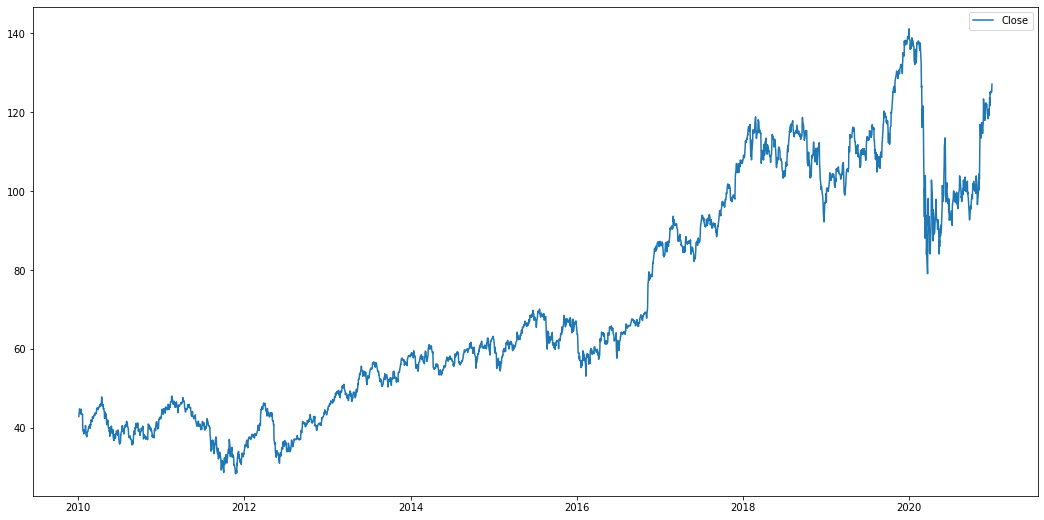

In [4]:
plt.figure(figsize=(18, 9))
plt.plot(df['Close'])
plt.legend(['Close'])
plt.show()

# Scale the data and normalize

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.12838257],
       [0.13574661],
       [0.13787596],
       ...,
       [0.85733298],
       [0.86043829],
       [0.87560997]])

# Build the train and test data

In [10]:
train_length = int(len(scaled_data) * 0.9)
test_length = len(scaled_data) - train_length

train_data = scaled_data[0:train_length, :]
test_data = scaled_data[train_length:len(scaled_data), :]

In [11]:
def create_dataset(dataset, timestep):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i:(i + timestep), 0])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [12]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# Build the model

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='loss', patience=1)
model.fit(train_x, train_y, epochs=200, verbose=1, callbacks=[early_stop])
score = model.evaluate(train_x, train_y, verbose=0)
print(f'Keras Model Loss = {score[0] * 100}')
print(f'Keras Model Accuracy = {score[1] * 100}')

Epoch 1/200
78/78 [==============================] - 34s 5ms/step - loss: 0.0682 - accuracy: 3.5392e-04
Epoch 2/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0072 - accuracy: 2.2082e-04
Epoch 3/200
78/78 [==============================] - 0s 4ms/step - loss: 7.1577e-04 - accuracy: 8.8423e-04
Epoch 4/200
78/78 [==============================] - 0s 5ms/step - loss: 6.3062e-04 - accuracy: 7.0714e-05
Epoch 5/200
78/78 [==============================] - 0s 4ms/step - loss: 5.4994e-04 - accuracy: 4.6568e-04
Epoch 6/200
78/78 [==============================] - 0s 4ms/step - loss: 4.8820e-04 - accuracy: 2.5722e-04
Epoch 7/200
78/78 [==============================] - 0s 4ms/step - loss: 4.5681e-04 - accuracy: 1.4224e-04
Epoch 8/200
78/78 [==============================] - 0s 4ms/step - loss: 4.2105e-04 - accuracy: 0.0012
Epoch 9/200
78/78 [==============================] - 0s 4ms/step - loss: 4.0741e-04 - accuracy: 2.0505e-05
Epoch 10/200
78/78 [============================

# Plotting the results

P.S: Can be improved

In [15]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform([test_y])

train_pred_plot = np.empty_like(scaled_data)
train_pred_plot[:, :] = np.nan
train_pred_plot[1:len(train_pred) + 1, :] = train_pred

test_pred_plot = np.empty_like(scaled_data)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred)+2 + 1:len(scaled_data)-1, :] = test_pred

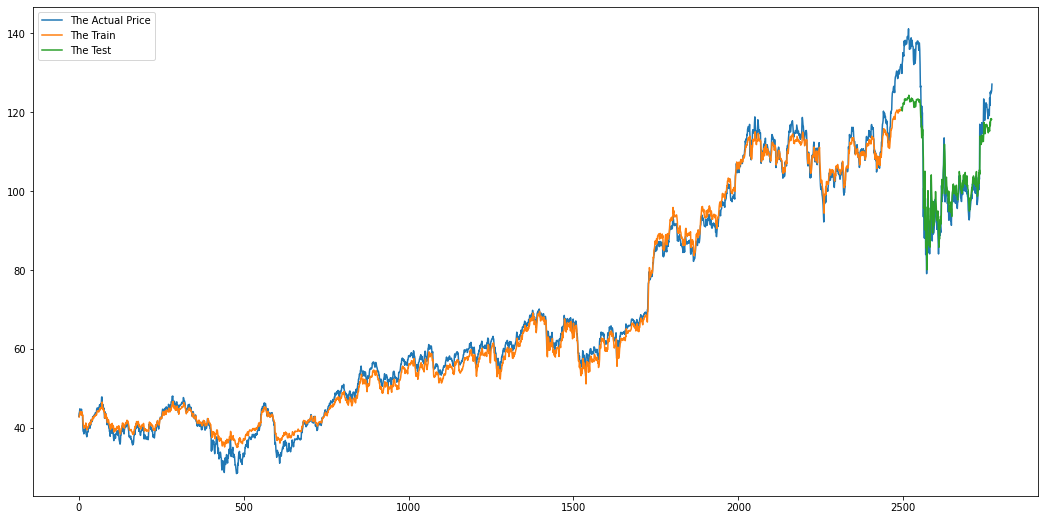

In [24]:
plt.figure(figsize=(18, 9))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.legend(['The Actual Price', 'The Train', 'The Test'])
plt.show()